# Spatial Transformer Network with IDSIA-like convolutional neural network for German Traffic Signs Dataset classification

**Note:** Due to large datasets sizes, I cannot provide them with this notebook. If you are interested in reproducing the results of this notebook, ping me, and I'll gladly send you both color and grayscale datasets.

In [63]:
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import random

from lib import drawing_routines

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from skimage import exposure, transform, color
import os
import ipyparallel as ipp
import multiprocessing

from sklearn.utils import shuffle
from copy import deepcopy

from scipy.stats import spearmanr
from sklearn import preprocessing

data_dir = 'data/'

training_file = data_dir + 'train.p'
validation_file = data_dir + 'valid.p'
testing_file = data_dir + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import matplotlib.pyplot as plt

## Data Discovery

### Totals

In [65]:
labels = pd.read_csv('signnames.csv')['SignName']

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

value_counts_train = pd.Series(y_train).value_counts(sort=False, dropna=False).sort_index()
value_counts_valid = pd.Series(y_valid).value_counts(sort=False, dropna=False).sort_index()
value_counts_test = pd.Series(y_test).value_counts(sort=False, dropna=False).sort_index()

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Training set

In [66]:
value_counts_train.describe(percentiles=np.arange(0.1,1.0,0.1))

count      43.000000
mean      809.279070
std       626.750855
min       180.000000
10%       210.000000
20%       252.000000
30.0%     318.000000
40%       360.000000
50%       540.000000
60%       750.000000
70%      1206.000000
80%      1338.000000
90%      1848.000000
max      2010.000000
dtype: float64

### Validation set:

In [67]:
value_counts_valid.describe(percentiles=np.arange(0.1,1.0,0.1))

count     43.000000
mean     102.558140
std       69.662213
min       30.000000
10%       30.000000
20%       30.000000
30.0%     60.000000
40%       60.000000
50%       60.000000
60%       96.000000
70%      150.000000
80%      150.000000
90%      210.000000
max      240.000000
dtype: float64

### Testing set

In [68]:
value_counts_test.describe(percentiles=np.arange(0.1,1.0,0.1))

count     43.000000
mean     293.720930
std      233.442389
min       60.000000
10%       60.000000
20%       90.000000
30.0%    108.000000
40%      150.000000
50%      180.000000
60%      288.000000
70%      432.000000
80%      480.000000
90%      684.000000
max      750.000000
dtype: float64

### Distribution among classes

In [69]:
spearmanr(value_counts_train.values, value_counts_test.values)

SpearmanrResult(correlation=0.99400777328458556, pvalue=4.7901336677288399e-41)

In [70]:
spearmanr(value_counts_train.values, value_counts_valid.values)

SpearmanrResult(correlation=0.9795158921634155, pvalue=3.672585067925868e-30)

### Let's visualize things!

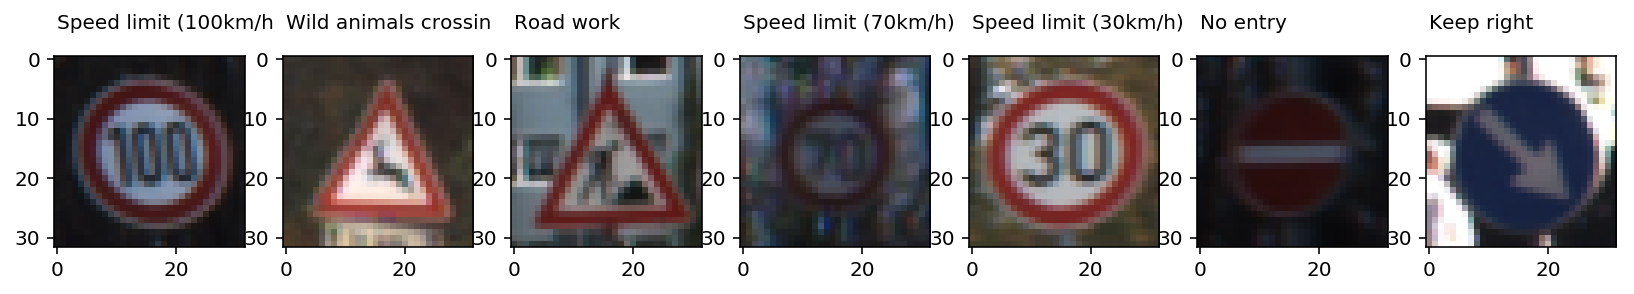

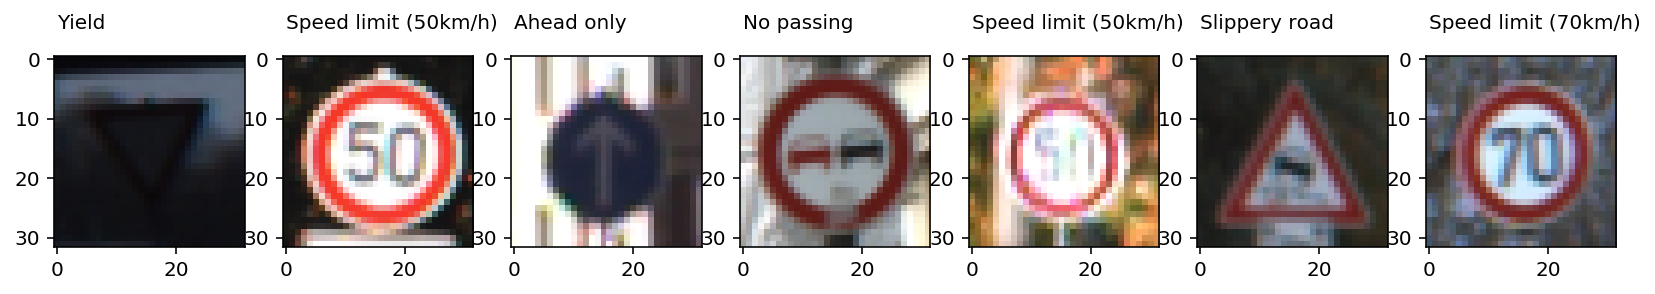

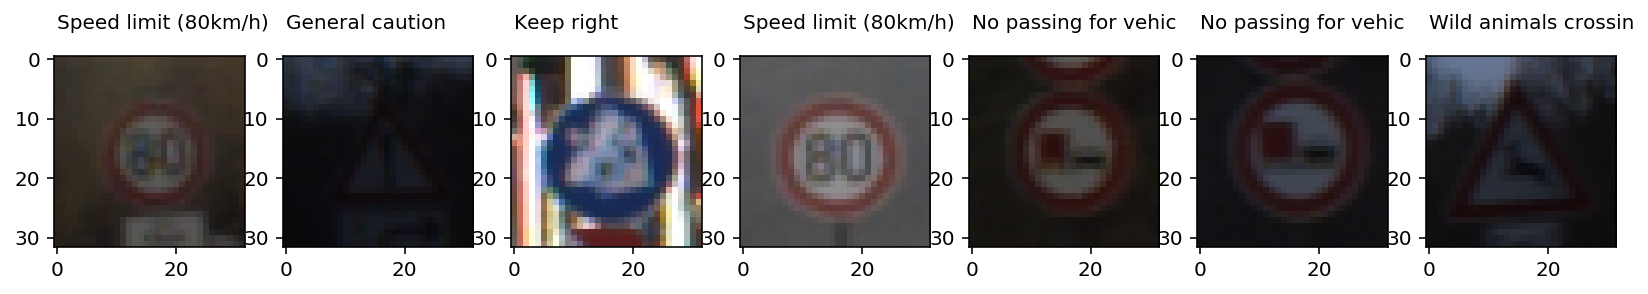

In [71]:
drawing_routines.draw_table(X_train, y_train)

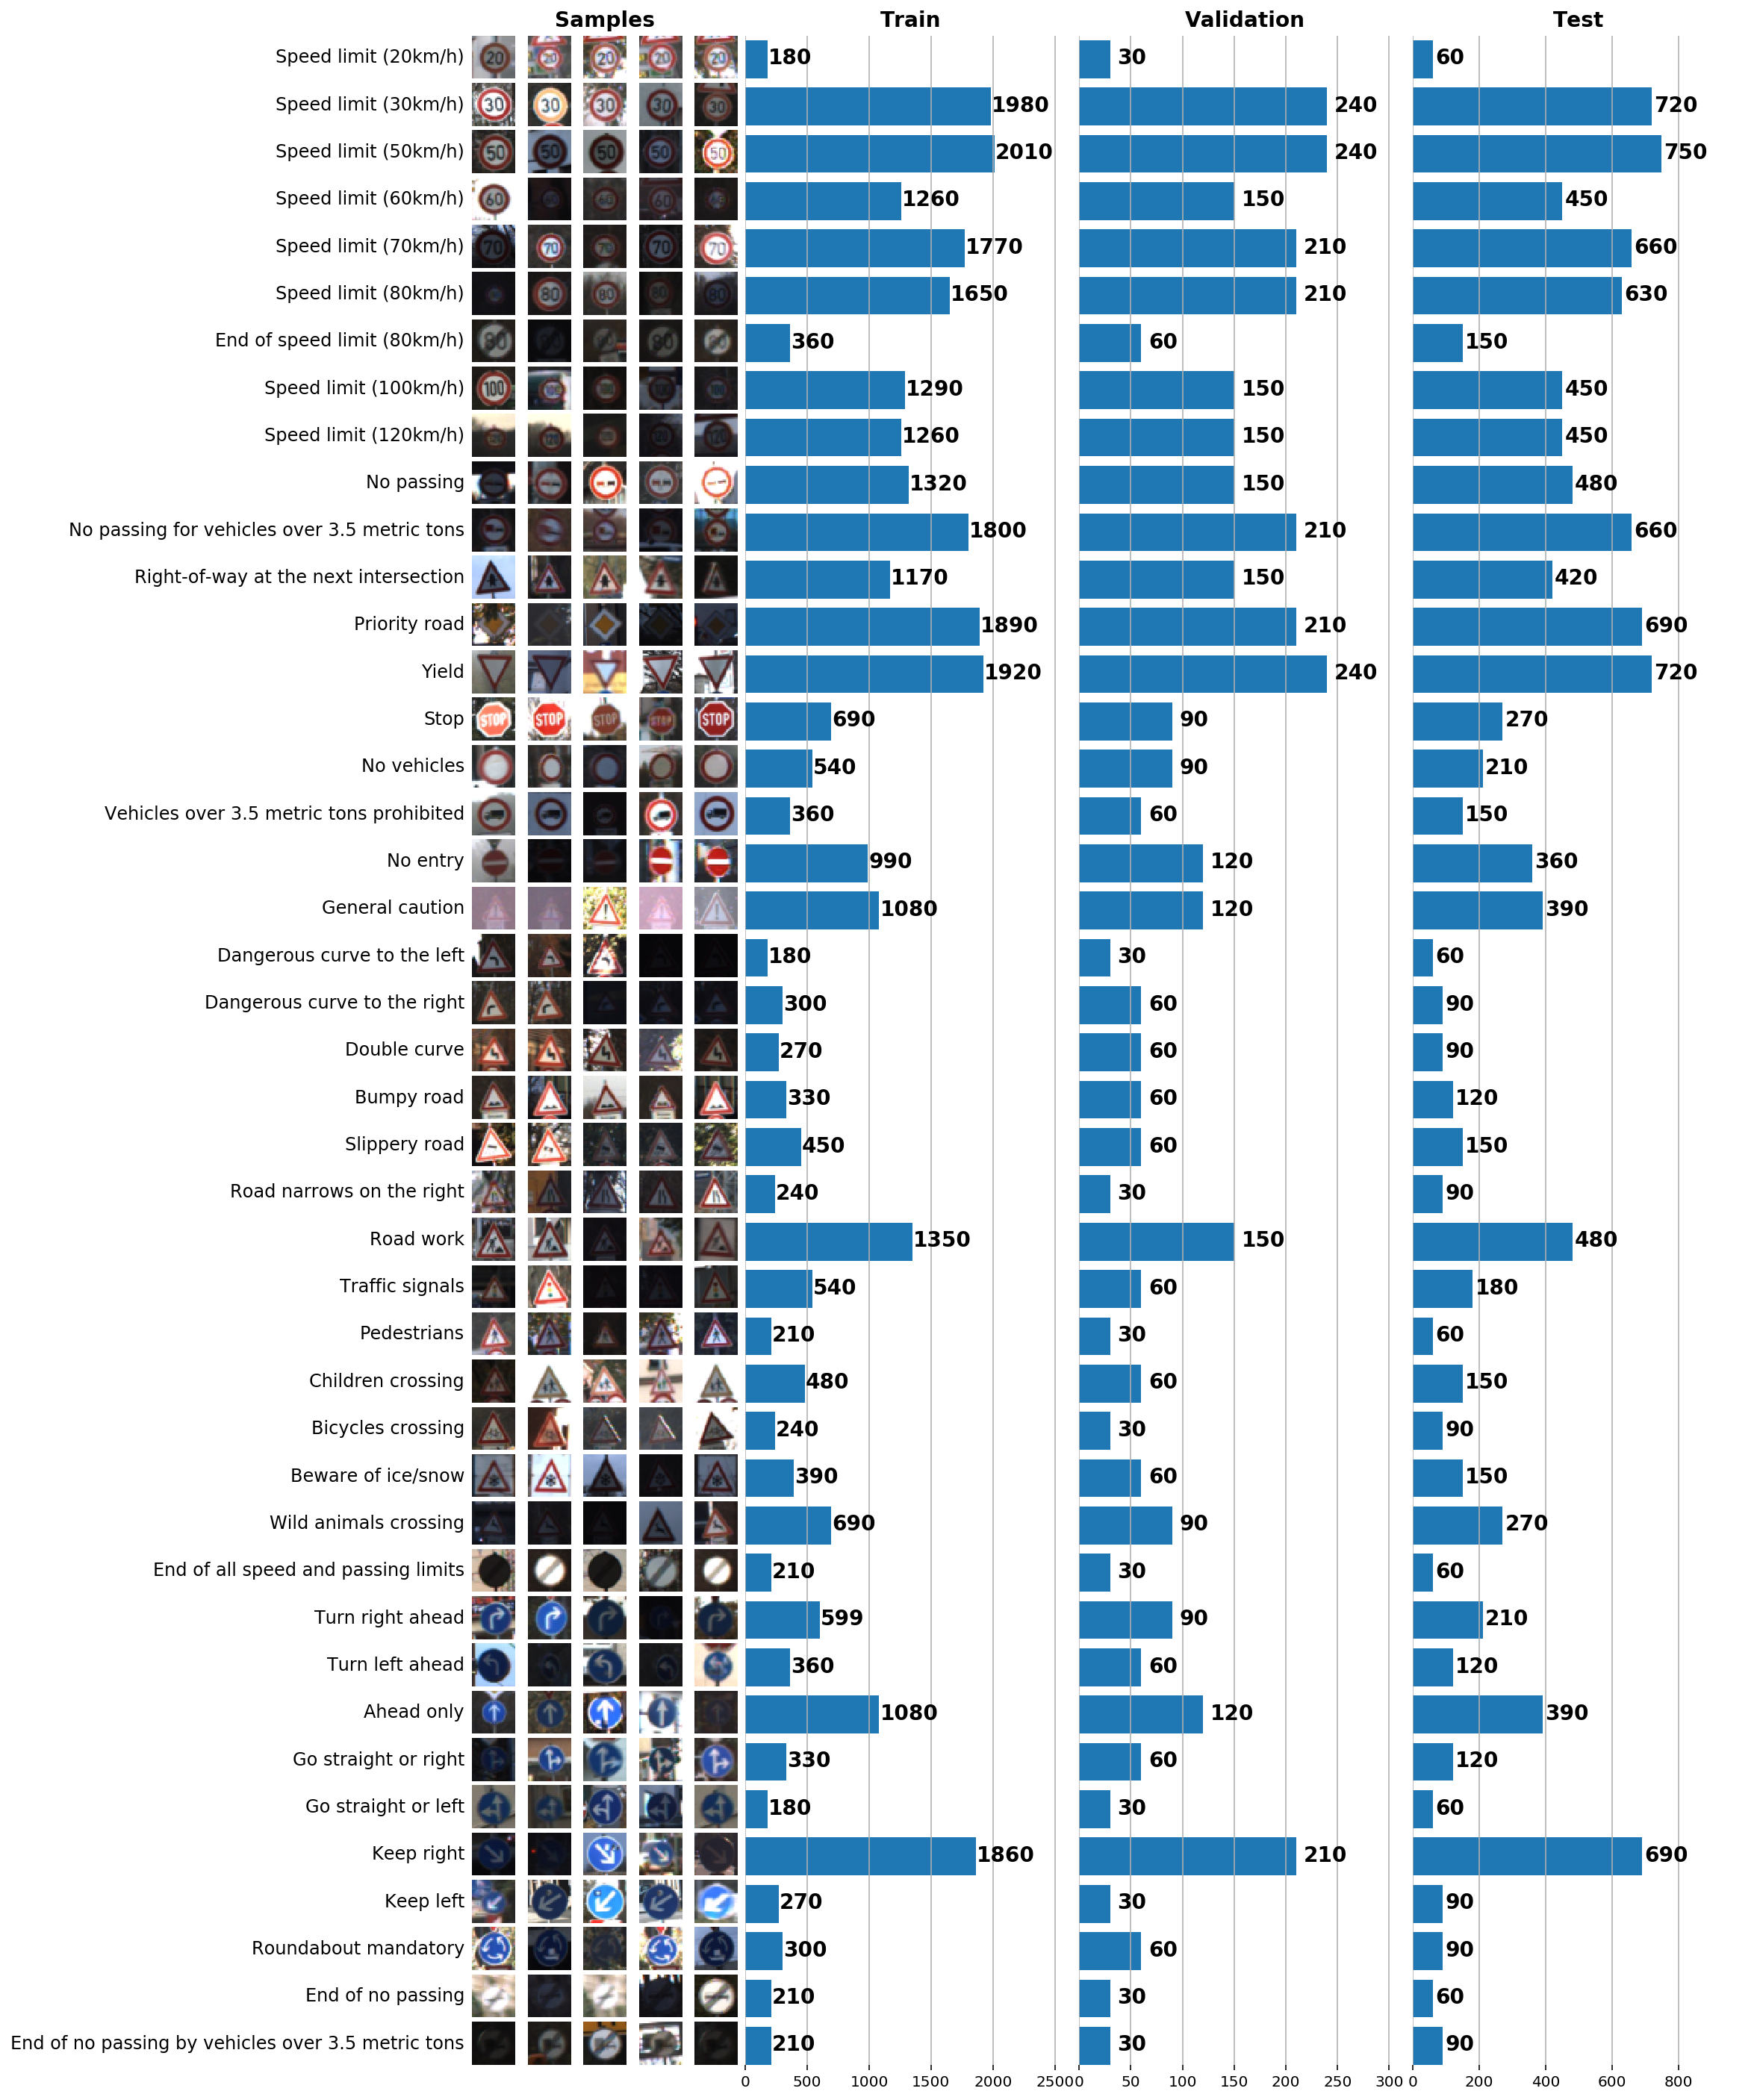

In [72]:
drawing_routines.draw_classes(X_train, y_train, X_valid, y_valid, X_test, y_test)

## Preprocessing

As seen in our previous visualization, the initial dataset is quite problematic to work with as is. Problems include:

* Huge difference in light conditions: some images are too bright, other are extremely dark.

* Very noisy images. Some of them are blurred, other include noisy background, rays of sunlight, shade, some of them even contain a part of another traffic sign.

* High variance in sign positions on the image, high variance of sign sizes, random rotations.

As data preprocessing is crucial, we implement a number of image enhancement routines. Our goal is to make dim and dark parts of the image brighter and sharper. In other words, enhance images with low contrast. The key is to normalize image's histogram: the most straightforward implementation can be found in `scikit-image` toolbox.

Two of our instruments include:

* A kernel-based CLAHE (adaptive contrast normalization): `skimage.exposure.equalize_adapthist`;
* Histogram equalization: `skimage.exposure.equalize_hist`.

Both can use grayscaled and color images.

Sources: 

* http://scikit-image.org/docs/stable/user_guide/transforming_image_data.html#contrast-and-exposure
* https://en.wikipedia.org/wiki/Adaptive_histogram_equalization

## IPython Parallel

Here is the sample from my IPython Parallel function that applies CLAHE to input images:

```python
def preprocess_equalize(X, y, equalizer=None, bins=256, cpu=multiprocessing.cpu_count()):
    
    """
    Source: https://en.wikipedia.org/wiki/Adaptive_histogram_equalization
    As seen in skimage: http://scikit-image.org/docs/dev/api/skimage.exposure.html

    Main function that manages multiprocessing logic. Requires `equalizer` function
    which specifies the type of transformation.    
    """
    
    if equalizer is None: raise Exception('Enter the equalizer function.')
    rc = ipp.Client()
    with rc[:].sync_imports():
        import numpy
        from skimage import exposure, transform, color        
    
    rc[:]['num_bins'] = bins
    X_processed = np.zeros(X.shape[:-1])
    y_processed = np.zeros(y.shape)
    
    subarrays_x = np.array_split(X, cpu)
    subarrays_y = np.array_split(y, cpu)
    subarrays = zip(subarrays_x, subarrays_y)
        
    preprocessed_subs = rc[:].map(equalizer, subarrays).get_dict()
    cnt = 0
    for _,v in preprocessed_subs.items():
        x_, y_ = v[0], v[1]
        X_processed[cnt:cnt+len(x_)] = x_
        y_processed[cnt:cnt+len(y_)] = y_
        cnt += len(x_)
    
    return X_processed.reshape(X_processed.shape + (1,)), y_processed
```

### Collecting results

In [73]:
%store -r X_tr_256
%store -r y_tr_256
%store -r X_val_256
%store -r y_val_256

In [74]:
%store -r X_tr_256_c
%store -r y_tr_256_c
%store -r X_val_256_c
%store -r y_val_256_c

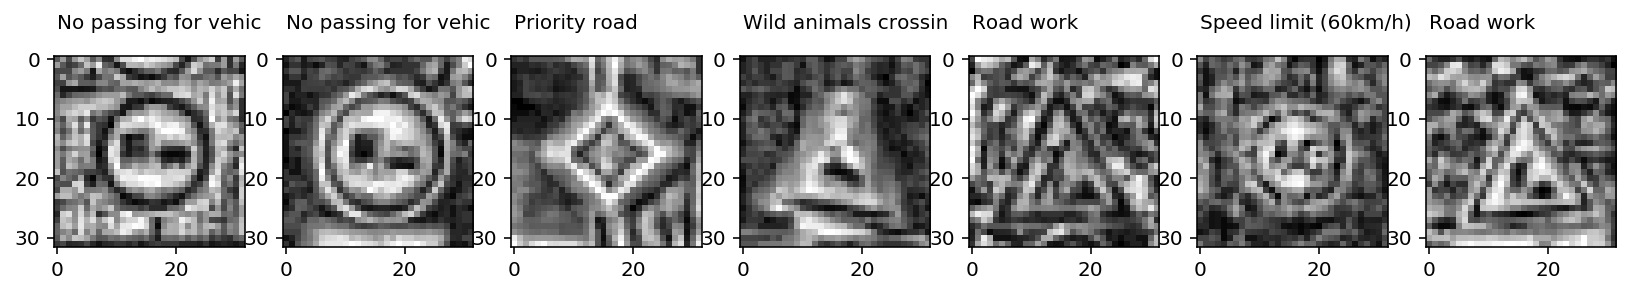

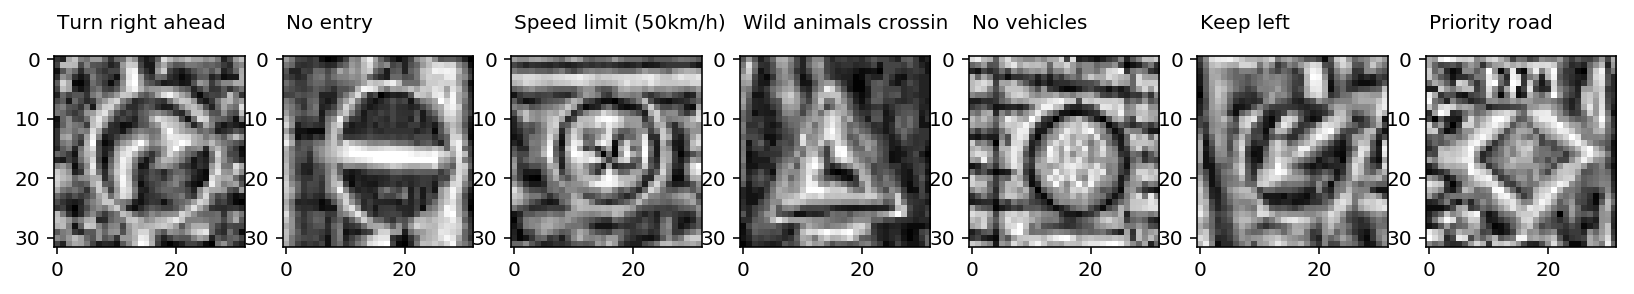

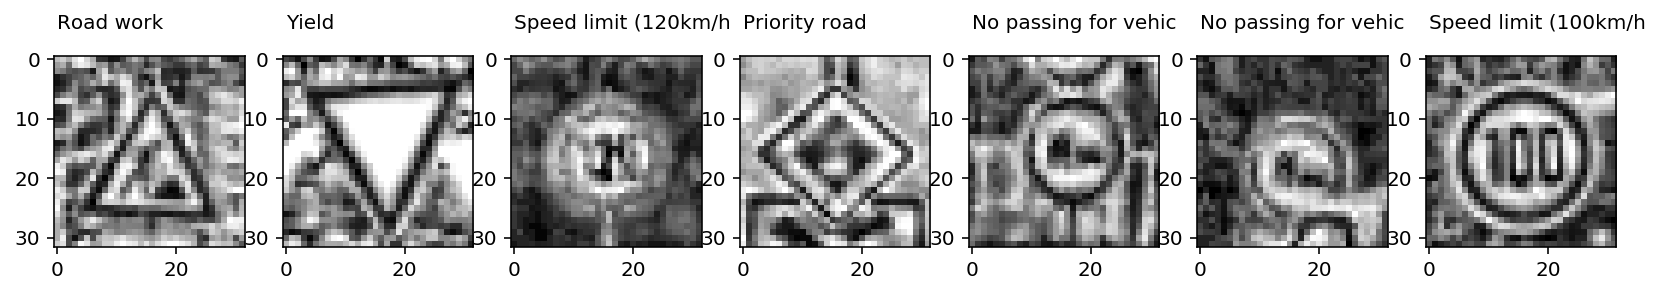

In [75]:
drawing_routines.draw_table(X_tr_256, y_tr_256)

## Batch generator

In [76]:
def batch_generator(X, y, batch_size):
    X_aug, y_aug = shuffle(X, y)
    
    # Batch generation
    for offset in range(0, X_aug.shape[0], batch_size):
        end = offset + batch_size
        batch_x, batch_y = X_aug[offset:end,...], y_aug[offset:end]
        
        yield batch_x, batch_y

# CNN Training with TensorFlow

In [77]:
import tensorflow as tf

from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import batch_norm
from spatial_transformer import transformer
from tf_utils import weight_variable, bias_variable, dense_to_one_hot

# Resetting DAG to avoid collisions with previously initialized graph
# This is extremely important because TF caches variables and outputs VERY weird results/scores in case you
# forget this clean up.

tf.reset_default_graph()

TF_CONFIG = {
    'epochs': 10,
    'batch_size': 256,
    'channels': 1
}

BATCH_SIZE = 256

### Generic operations for TensorFlow

In [78]:
### Conv layers ops

def convolution_relu(batch_x, kernel_shape, bias_shape, strides=1):
    w_conv = tf.get_variable("w_conv", shape=kernel_shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())
    b_conv = tf.get_variable("b_conv", shape=bias_shape, initializer=tf.constant_initializer(0.0))
    
    convolution = tf.nn.conv2d(batch_x, w_conv, strides=[1, strides, strides, 1], padding='SAME')
    convolution = tf.add(convolution, b_conv)
    return tf.nn.relu(convolution)

def convolution_relu_batchnorm(batch_x, kernel_shape, bias_shape, strides=1):
    activation = convolution_relu(batch_x, kernel_shape, bias_shape)
    return batch_norm(activation)

def maxpooling(batch_x, k=2):
    return tf.nn.max_pool(batch_x, ksize=[1,k,k,1], strides=[1,k,k,1], padding='SAME')

### Generic fully-connected ops

def fc_matmul_logits(batch_x, weights_shape, bias_shape):
    w_fc = tf.get_variable("w_fc", shape=weights_shape, initializer=tf.contrib.layers.xavier_initializer())
    b_fc = tf.get_variable("b_fc", shape=bias_shape, initializer=tf.constant_initializer(0.0))

    linear_transform = tf.add(tf.matmul(batch_x, w_fc), b_fc)
    return linear_transform

def fc_matmul_relu(batch_x, weights_shape, bias_shape):
    linear_transform = fc_matmul_logits(batch_x, weights_shape, bias_shape)
    return tf.nn.relu(linear_transform)

def fc_matmul_relu_dropout(batch_x, weights_shape, bias_shape, dropout_keep):
    return tf.nn.dropout(fc_matmul_relu(batch_x, weights_shape, bias_shape), dropout_keep)

### Composite fully-connected ops

def fc_batchnorm_matmul_logits(batch_x, weights_shape, bias_shape):   
    batch_x_norm = batch_norm(batch_x)
    return fc_matmul_logits(batch_x_norm, weights_shape, bias_shape)

def fc_batchnorm_matmul_relu(batch_x, weights_shape, bias_shape):
    batch_x_norm = batch_norm(batch_x)
    return fc_matmul_relu(batch_x_norm, weights_shape, bias_shape)

def fc_batchnorm_matmul_relu_dropout(batch_x, weights_shape, bias_shape, dropout_keep):
    activation = fc_batchnorm_matmul_relu(batch_x, weights_shape, bias_shape)
    return tf.nn.dropout(activation, dropout_keep)

## Spatial Transformer Network

### Convolutional part of localization network

In [79]:
def stn_convolve_pool_flatten_type2(batch_x):
    kernels = {
        'conv1': [5, 5, TF_CONFIG['channels'], 100],
        'conv2': [5, 5, 100, 200],
    }
    biases = {
        'conv1': [100],
        'conv2': [200],
    }
    
    with tf.variable_scope('stn_conv1'):
        pooled_batch_x = maxpooling(batch_x, k=2)
        # Layer 1 and 2: Convolution -> Activation 
        activation1 = convolution_relu_batchnorm(pooled_batch_x, kernels['conv1'], biases['conv1'])
        
        # Layer 3: Max Pooling
        pool1 = maxpooling(activation1, k=2)
        
    with tf.variable_scope('stn_conv2'):
        # Layer 4 and 5: Convolution -> Activation
        activation2 = convolution_relu_batchnorm(pool1, kernels['conv2'], biases['conv2'])
        
        # Layer 6: Max Pooling
        pool2 = maxpooling(activation2, k=2)


    # Layer 9: Flatten
        pool1 = maxpooling(pool1, k=4)
        pool2 = maxpooling(pool2, k=2)

        flat_features = tf.concat([flatten(pool1), flatten(pool2)], 1)
        
        return flat_features

### Fully-connected part of localization network

In [80]:
def stn_locnet_type2(flat_features):
    weights = {
        'fc1': [1200, 100],
        'out': [100, 6]
    }
    
    biases = {
        'fc1': [100],
        'out': [6]
    }
    with tf.variable_scope('locnet_fc1'):       
        W_fc1 = tf.Variable(tf.zeros([1200, 100]), name='sp_weight_fc1')
        b_fc1 = tf.Variable(tf.zeros([100]), name='sp_biases_fc1')

        sp_fc1 = batch_norm(flat_features)            
        sp_fc1 = tf.add(tf.matmul(sp_fc1, W_fc1), b_fc1)
        sp_fc1 = tf.nn.relu(sp_fc1)
        sp_fc1 = tf.nn.dropout(sp_fc1, dropout_loc)

    with tf.variable_scope('locnet_fc2'):
        initial = np.array([[1.0, 0, 0], [0, 1.0, 0]])
        initial = initial.astype('float32')
        initial = initial.flatten()

        W_fc2 = tf.Variable(tf.zeros([100, 6]), name='sp_weight_fc2')
        b_fc2 = tf.Variable(initial_value=initial, name='sp_biases_fc2')
        
        sp_fc2 = batch_norm(sp_fc1)
        sp_fc2 = tf.add(tf.matmul(sp_fc2, W_fc2), b_fc2)

        return sp_fc2

### Main network: IDSIA

### Part 1 — Convolutional Layers

In [81]:
def idsia_convolve_pool_flatten(batch_x, multiscale=True):
    # Input: batch_size * 32 * 32 * 1 images
    # Multiscale uses features from both conv layers
    
    kernels = {
        'conv1': [7, 7, TF_CONFIG['channels'], 100],
        'conv2': [4, 4, 100, 150],
        'conv3': [4, 4, 150, 250]
    }
    biases = {
        'conv1': [100],
        'conv2': [150],
        'conv3': [250]
    }
    
    with tf.variable_scope('conv1'):
        # Layer 1 and 2: Convolution -> Activation 
        activation1 = convolution_relu(batch_x, kernel_shape=kernels['conv1'], bias_shape=biases['conv1'])
        
        # Layer 3: Max Pooling
        pool1 = maxpooling(activation1, k=2)
        
    with tf.variable_scope('conv2'):
        # Layer 4 and 5: Convolution -> Activation
        activation2 = convolution_relu(pool1, kernel_shape=kernels['conv2'], bias_shape=biases['conv2'])
        
        # Layer 6: Max Pooling
        pool2 = maxpooling(activation2, k=2)

    with tf.variable_scope('conv3'):
        # Layer 7 and 8: Convolution -> Activation
        activation3 = convolution_relu(pool2, kernel_shape=kernels['conv3'], bias_shape=biases['conv3'])
        pool3 = maxpooling(activation3, k=2)
                
    # Layer 9: Flatten
    pool1 = maxpooling(pool1, k=8)
    pool2 = maxpooling(pool2, k=4)
    pool3 = maxpooling(pool3, k=2)
    
    if multiscale is True:
        flat_features = tf.concat([flatten(pool1), flatten(pool2), flatten(pool3)], 1)
    else:
        flat_features = flatten(activation3)

    return flat_features, activation1

### Part 2 — Fully connected layers

In [82]:
def idsia_fc_logits(batch_x, multiscale=True):
    weights = {
        'fc1': [3200, 100],
        'fc1_multi': [2000, 300],
        'out': [300, n_classes]
    }
    
    biases = {
        'fc1': [300],
        'out': [n_classes]
    }
    
    with tf.variable_scope('fc1'):
        if multiscale is True:
            activation1 = fc_batchnorm_matmul_relu_dropout(batch_x, weights['fc1_multi'], biases['fc1'], dropout_keep=dropout_fc1)
        else:
            activation1 = fc_batchnorm_matmul_relu_dropout(batch_x, weights['fc1'], bias_shape=biases['fc1'], dropout_keep=dropout_fc1)
        
    with tf.variable_scope('out'):
        logits = fc_batchnorm_matmul_logits(activation1, weights['out'], biases['out'])
    
    return logits

### Part 3 — Building the network: inference

In [83]:
def stn_idsia_inference_type2(batch_x):
    with tf.name_scope('stn_network_t2'):
        stn_output = stn_locnet_type2(stn_convolve_pool_flatten_type2(batch_x))
        transformed_batch_x = transformer(batch_x, stn_output, (32,32, TF_CONFIG['channels']))

    with tf.name_scope('idsia_classifier'):
        features, batch_act = idsia_convolve_pool_flatten(transformed_batch_x, multiscale=True)
        logits = idsia_fc_logits(features, multiscale=True)

    return logits, transformed_batch_x, batch_act

### Part 4 — Metrics, parameters and network initialization

In [84]:
def calculate_loss(logits, one_hot_y):
    with tf.name_scope('Predictions'):
        predictions = tf.nn.softmax(logits)
    with tf.name_scope('Model'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
    with tf.name_scope('Loss'):
        loss_operation = tf.reduce_mean(cross_entropy)
    return loss_operation


boundaries = [100, 250, 500, 1000, 8000]
values = [0.02, 0.01, 0.005, 0.003, 0.001, 0.0001]


starter_learning_rate = 0.02
global_step = tf.Variable(0, trainable=False)

learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)

# learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 50, 0.5, staircase=True)
with tf.name_scope('dropout'):
    dropout_conv = tf.placeholder(tf.float32)
    dropout_fc1 = tf.placeholder(tf.float32)
    dropout_loc = tf.placeholder(tf.float32)

with tf.name_scope('batch_data'):
    x = tf.placeholder(tf.float32, (None, 32, 32, TF_CONFIG['channels']), name="InputData")
    y = tf.placeholder(tf.int32, (None), name="InputLabels")
    one_hot_y = tf.one_hot(y, n_classes, name='InputLabelsOneHot')

#### INIT
with tf.name_scope('logits_and_stn_output'):
    logits, stn_output, batch_act = stn_idsia_inference_type2(x)

#########

with tf.name_scope('bool_correct_prediction'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    casted_corr_pred = tf.cast(correct_prediction, tf.float32)

with tf.name_scope('accuracy'):
    accuracy_operation = tf.reduce_mean(casted_corr_pred)

with tf.name_scope('loss_calculation'):
    loss_operation = calculate_loss(logits, one_hot_y)

with tf.name_scope('adam_optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

with tf.name_scope('training_backprop_operation'):
    training_operation = optimizer.minimize(loss_operation, global_step=global_step)

### Part 5 — Network evaluation

In [85]:
def evaluate(X_data, y_data, batch_size=256):
    end = 0
    correct_pred = np.empty(y_data.shape)
    acc = []
    eval_loss = []
    sess = tf.get_default_session()
    
    for start in range(0, len(X_data), batch_size):
        
        correct_pred_batch, loss_batch = sess.run([casted_corr_pred, loss_operation],  
                                             feed_dict={x: X_data[start:end+batch_size], 
                                                        y: y_data[start:end+batch_size], 
                                                        dropout_conv: 1.0, dropout_loc: 1.0,
                                                        dropout_fc1: 1.0})
        
        correct_pred[start:end+batch_size] = correct_pred_batch
        eval_loss.append(loss_batch)
        end += batch_size
    print("+: {} / -: {}".format(np.sum(correct_pred), len(correct_pred)-np.sum(correct_pred)))
    return np.sum(correct_pred) / y_data.shape[0], np.average(eval_loss)

In [86]:
def console_log(data, batch, train_writer, val_writer):
    tr_sample_x, tr_sample_y = shuffle(data['X_train'], data['y_train'])
    tr_sample_x, tr_sample_y = tr_sample_x[:256], tr_sample_y[:256]
    
    # Accuracy on the whole validation data
    acc, l = evaluate(data['X_valid'], data['y_valid'])

    data['X_valid'], data['y_valid'] = shuffle(data['X_valid'], data['y_valid'])
    
    # Accuracy on one batch from validation set (to make sure everything is OK)
    val_acc_control, summary = sess.run([accuracy_operation, merged_summary_op],
                 feed_dict={x: data['X_valid'][:256], 
                            y: data['y_valid'][:256],
                            dropout_conv: 1.0,
                            dropout_loc: 1.0,
                            dropout_fc1: 1.0})
    val_writer.add_summary(summary, batch)

    # Accuracy on one batch from training set (to compare with validation)
    tr_acc, summary = sess.run([accuracy_operation, merged_summary_op], 
                 feed_dict={x: tr_sample_x, 
                            y: tr_sample_y, 
                            dropout_conv: 1.0,
                            dropout_loc: 1.0,
                            dropout_fc1: 1.0})
    train_writer.add_summary(summary, batch)
    
    # Output activations
    
    print("Batch {}: val_acc = {:.3f}, val_acc_ctrl = {:.3f}, batch_train_acc = {:.3f}, val_loss = {:.3f}, lr = {:.3f}".format(batch, acc, val_acc_control, tr_acc, l, lr))

### Part 6 — Training

In [87]:
### TRAINING #####

batch = 0

log_dir = '/tmp/traffic_signs/idsia_stn'

tf.summary.scalar("loss", loss_operation)

tf.summary.scalar("accuracy", accuracy_operation)

merged_summary_op = tf.summary.merge_all()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
val_writer = tf.summary.FileWriter(log_dir + '/valid')

train_val_data = {
    'X_train': X_tr_256,
    'y_train': y_tr_256,
    'X_valid': X_val_256,
    'y_valid': y_val_256
}

num_examples = len(train_val_data['X_train'])

for i in range(TF_CONFIG['epochs']):
    # Shuffling data, just in case
    train_val_data['X_train'], train_val_data['y_train'] = shuffle(train_val_data['X_train'], 
                                                                   train_val_data['y_train'])
    for batch_x, batch_y in batch_generator(train_val_data['X_train'], 
                                            train_val_data['y_train'], 
                                            batch_size=TF_CONFIG['batch_size']):

        _, loss, lr = sess.run([training_operation, loss_operation, learning_rate],
                               feed_dict={x: batch_x, 
                                          y: batch_y, 
                                          dropout_conv: 1.0,
                                          dropout_loc: 0.9,
                                          dropout_fc1: 0.3})
        
        if batch % 50 == 0:
            console_log(train_val_data, batch, train_writer, val_writer)
        batch += 1
        
    print("EPOCH {} COMPLETED. STATISTICS:".format(i+1 ))
    print("Loss = {:.3f}".format(loss))
    print("LR = {:.3f}".format(lr))
    print("Validation Accuracy = {:.3f}".format(evaluate(train_val_data['X_valid'], train_val_data['y_valid'])[0]))
    print("Train Accuracy = {:.3f}".format(evaluate(train_val_data['X_train'], train_val_data['y_train'])[0]))
    print()

+: 160.0 / -: 4250.0
Batch 0: val_acc = 0.036, val_acc_ctrl = 0.082, batch_train_acc = 0.082, val_loss = 4.789, lr = 0.020
+: 2978.0 / -: 1432.0
Batch 50: val_acc = 0.675, val_acc_ctrl = 0.652, batch_train_acc = 0.754, val_loss = 1.250, lr = 0.020
+: 4164.0 / -: 246.0
Batch 100: val_acc = 0.944, val_acc_ctrl = 0.891, batch_train_acc = 0.945, val_loss = 0.217, lr = 0.020
EPOCH 1 COMPLETED. STATISTICS:
Loss = 0.233
LR = 0.010
+: 4245.0 / -: 165.0
Validation Accuracy = 0.963
+: 34113.0 / -: 686.0
Train Accuracy = 0.980

+: 4264.0 / -: 146.0
Batch 150: val_acc = 0.967, val_acc_ctrl = 0.977, batch_train_acc = 0.992, val_loss = 0.130, lr = 0.010
+: 4282.0 / -: 128.0
Batch 200: val_acc = 0.971, val_acc_ctrl = 0.965, batch_train_acc = 0.992, val_loss = 0.114, lr = 0.010
+: 4302.0 / -: 108.0
Batch 250: val_acc = 0.976, val_acc_ctrl = 0.977, batch_train_acc = 0.996, val_loss = 0.094, lr = 0.010
EPOCH 2 COMPLETED. STATISTICS:
Loss = 0.177
LR = 0.005
+: 4328.0 / -: 82.0
Validation Accuracy = 0.981

## Results

In [88]:
def transform_with_stn(X_, y_, batch_size=1000):
    X_trans = np.zeros(X_.shape)
    y_trans = np.zeros(y_.shape)
    
    correct = []
    
    if batch_size > len(X_): batch_size = len(X_)

    for offset in range(0, len(X_), batch_size):
        X_trans[offset:offset+batch_size,...], cor = sess.run([stn_output, correct_prediction], 
                                                              feed_dict={x: X_[offset:offset+batch_size], 
                                                                  y: y_[offset:offset+batch_size], 
                                                                  dropout_conv: 1.0,
                                                                  dropout_fc1: 1.0, dropout_loc: 1.0})
        correct.extend(cor)
        y_trans[offset:offset+batch_size] = y_[offset:offset+batch_size]
    return X_trans, y_trans, correct

In [89]:
X_tr_stn, y_tr_stn, correct_train = transform_with_stn(train_val_data['X_train'], train_val_data['y_train'])
X_val_stn, y_val_stn, correct_val = transform_with_stn(train_val_data['X_valid'], train_val_data['y_valid'])

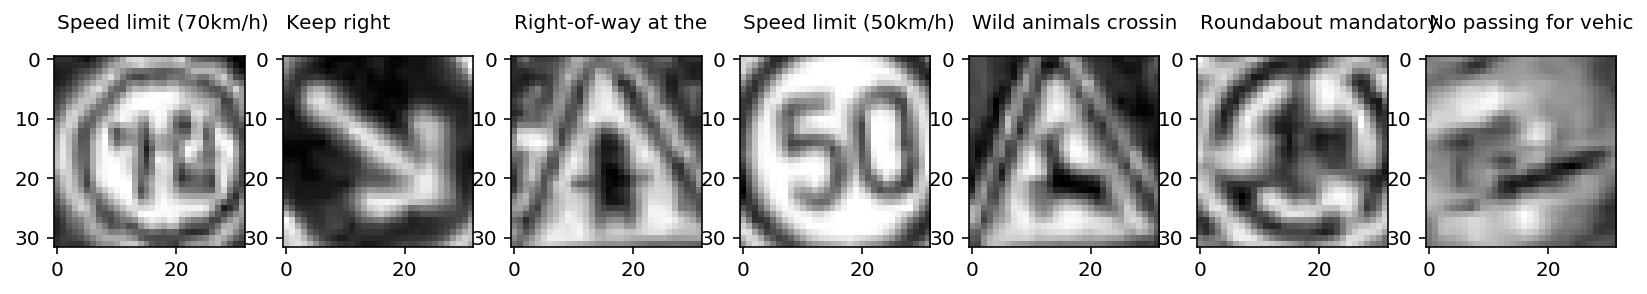

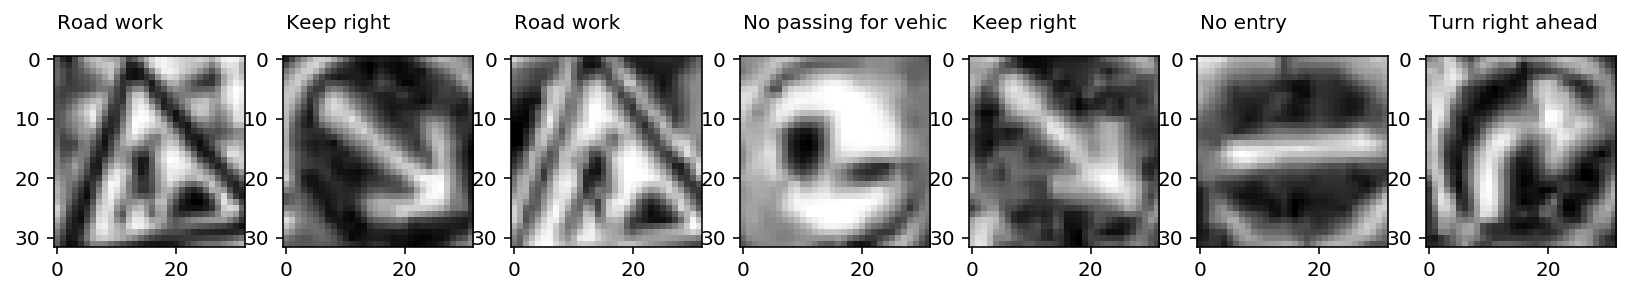

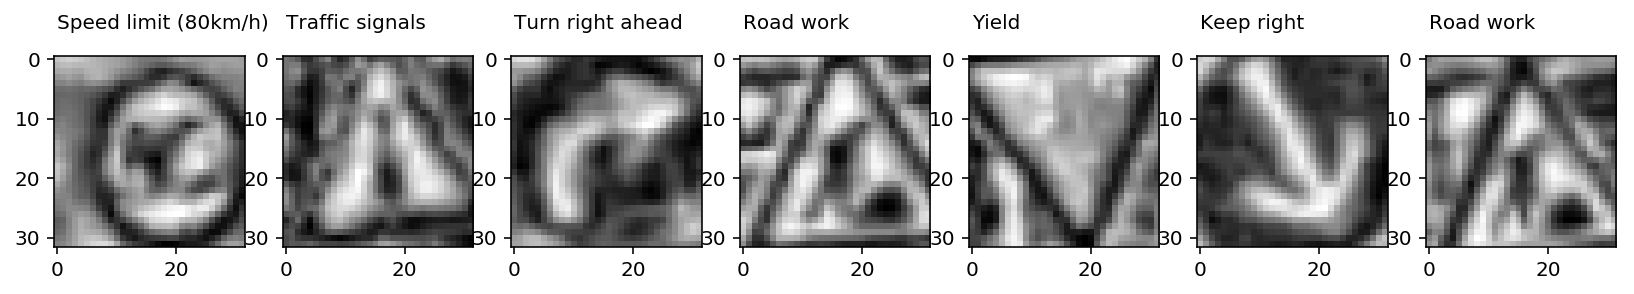

In [90]:
batch = X_val_stn
default = train_val_data['X_valid']
drawing_routines.draw_table(X_tr_stn, y_tr_stn)

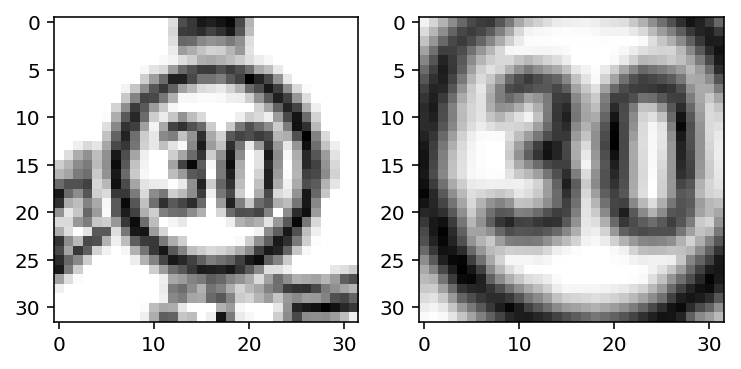

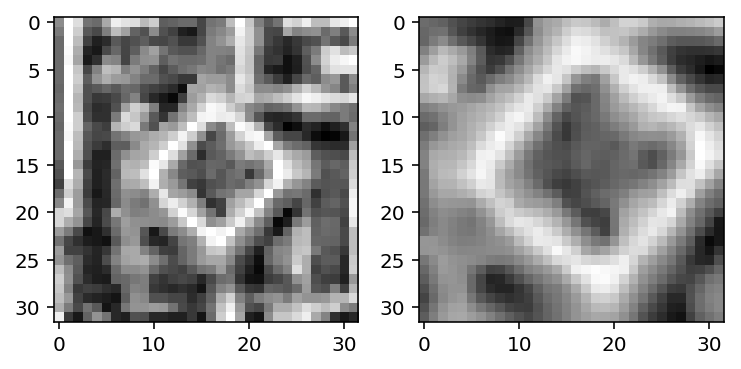

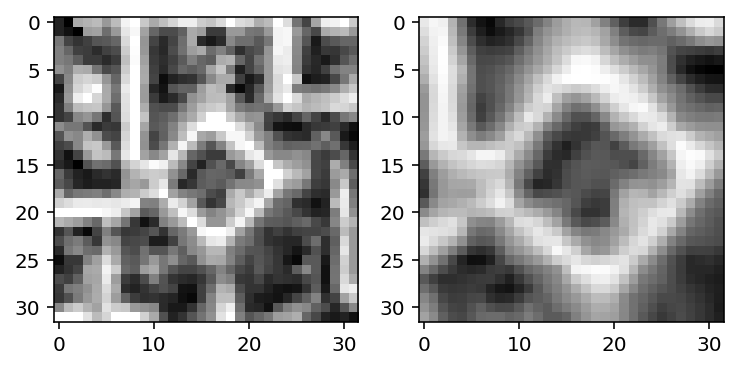

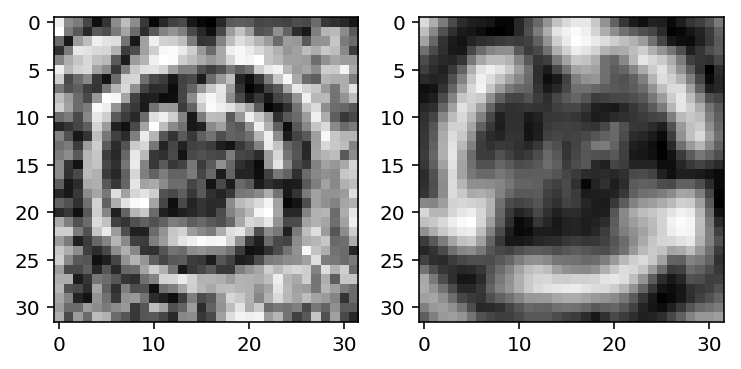

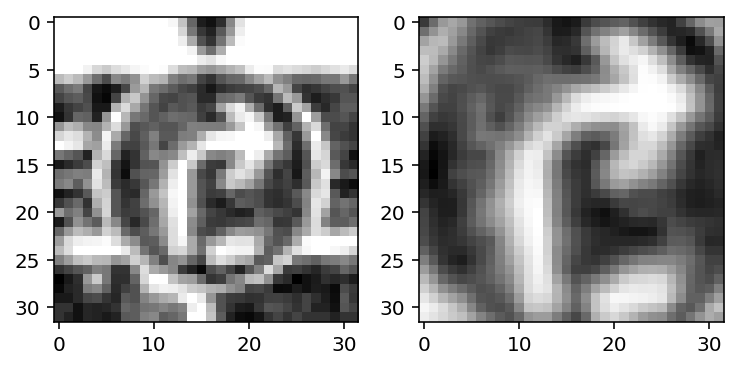

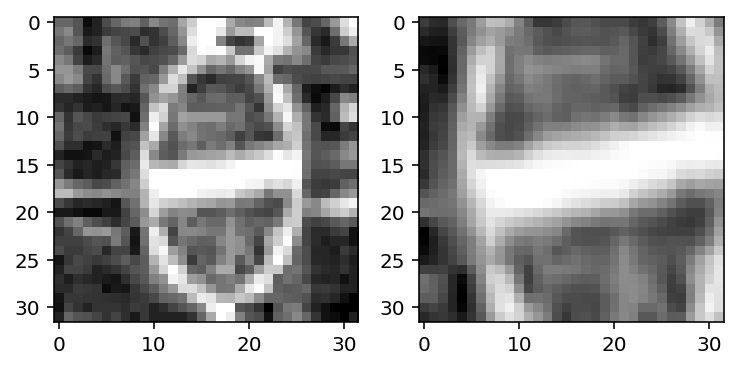

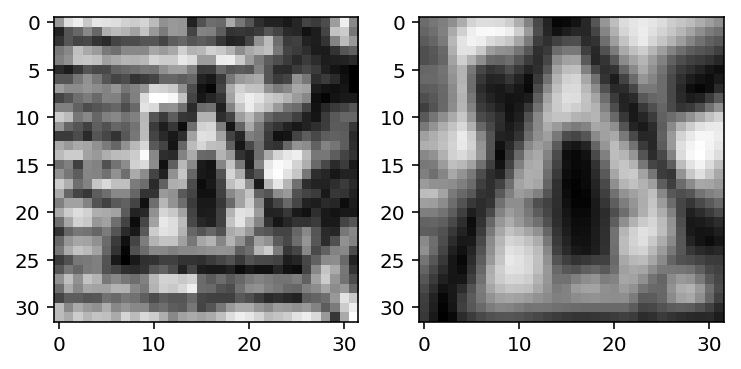

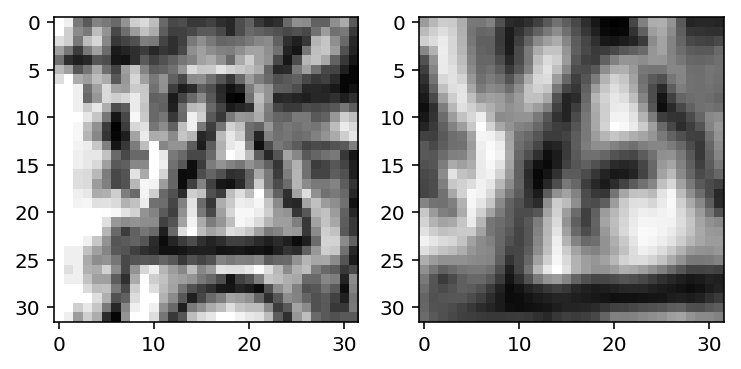

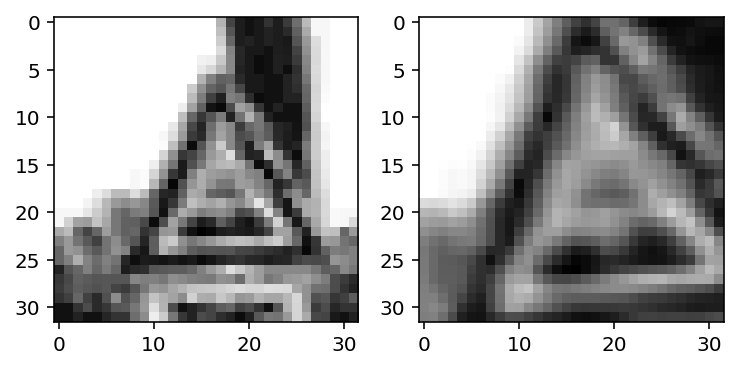

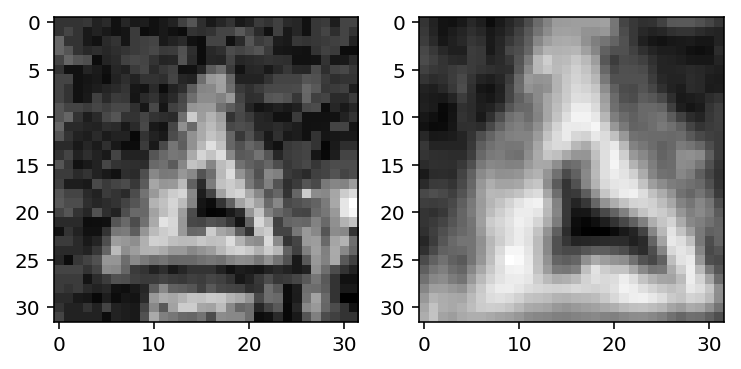

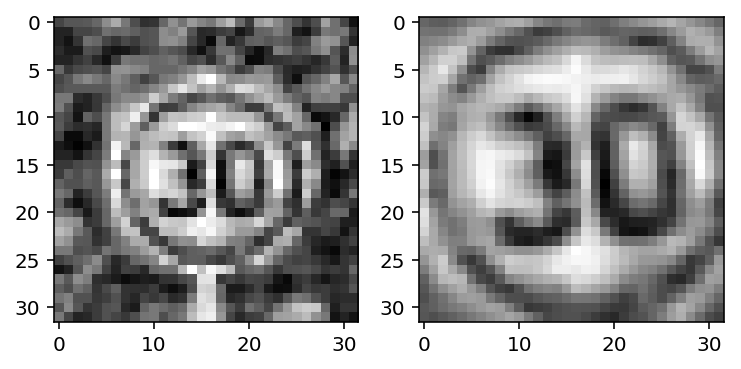

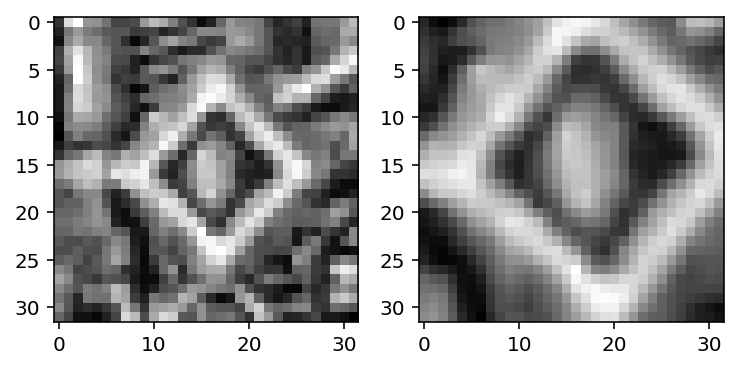

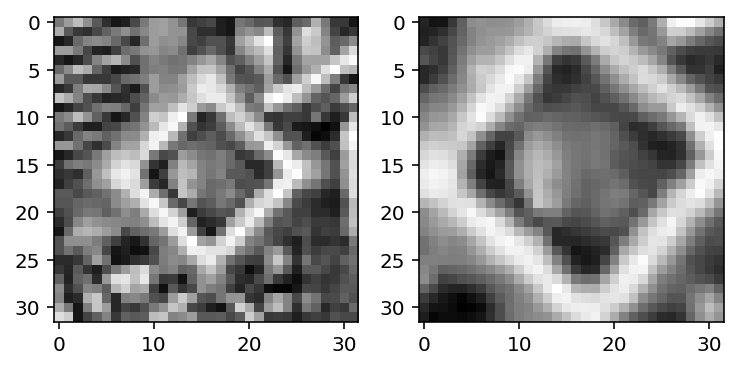

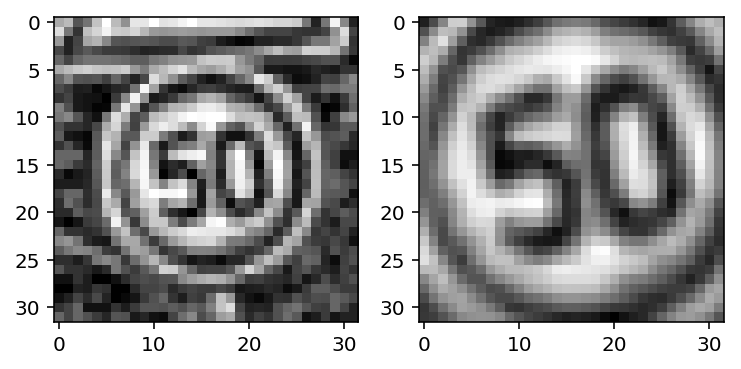

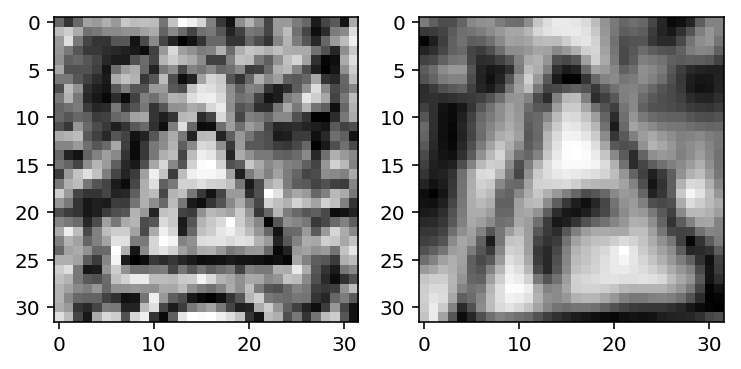

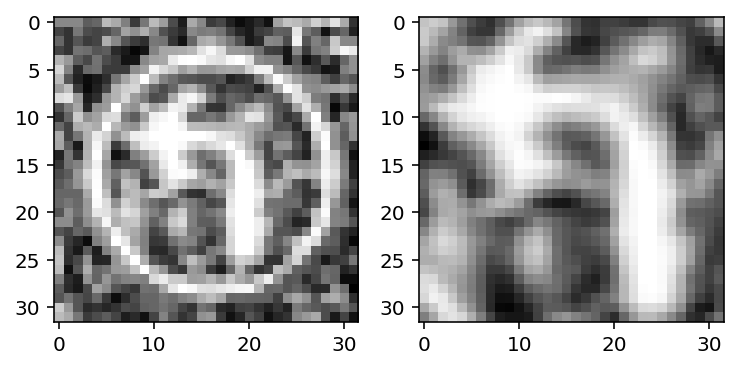

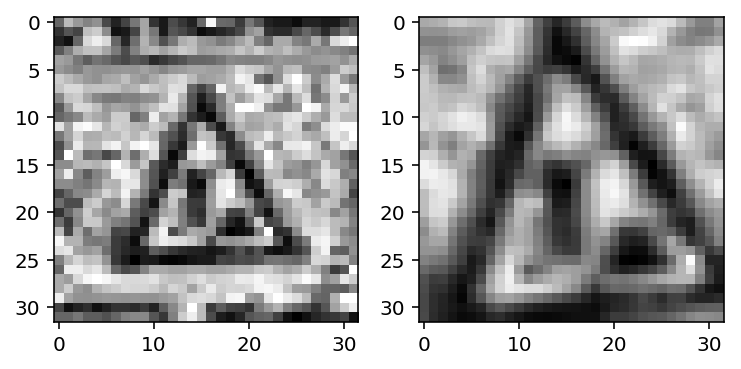

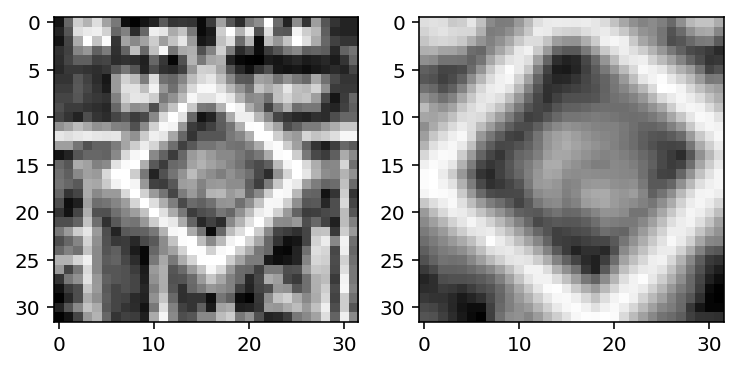

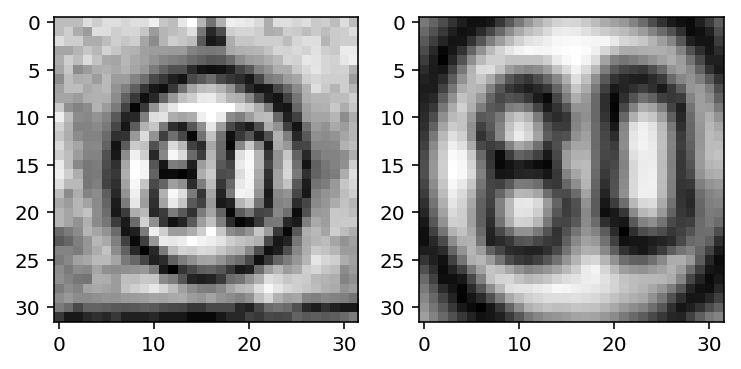

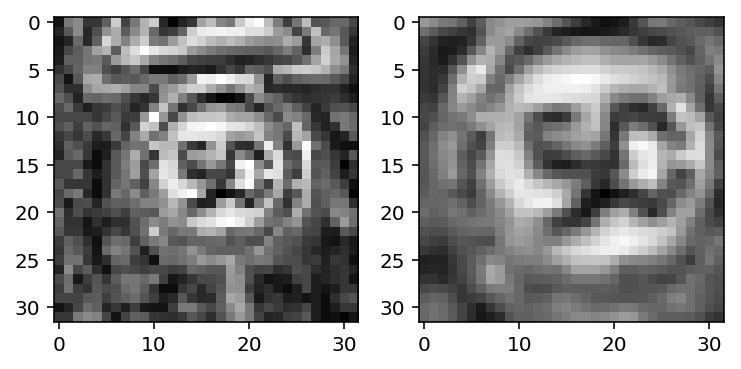

In [91]:
batch = X_val_stn
default = train_val_data['X_valid']

cols = 2
rows = 40
elements = cols*rows
idx = list(range(4*elements,5*elements))
next_row = drawing_routines.grouper(idx,cols)

for row in next_row:
    plt.figure()
    for col in range(cols):
        ix = idx.pop()
        plt.subplot(1,2,1)
        plt.imshow(default[ix].reshape(32,32), cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(batch[ix].reshape(32,32), cmap='gray')